# Estimacion de produccion de Aceite

In [314]:
#triada de la death
import pandas as pd
import numpy as np

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import cufflinks

font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams[u'figure.figsize'] = (12,8)
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         }

plt.style.use('ggplot')

# Modelos
import lightgbm as lgb
from sklearn.cluster import KMeans

# Interpretacion
import shap
from pdpbox import pdp, info_plots

#mis tools
import sys
sys.path.append('serch_tools/')
import serch_tools as st

In [316]:
aforos = pd.read_csv("datos/aforos.csv")
analisis_fluidos = pd.read_csv("datos/Analisis_fluidos.csv")
columna_geologica = pd.read_csv('datos/columna_geologica.csv')
eval_petrofisica = pd.read_csv('datos/eval_petrofisica.csv')
intervalo_disparado = pd.read_csv('datos/IntervalosDisparados.csv')
parametros_petrofisicos = pd.read_csv('datos/parametros_petrofisicos.csv')

In [317]:
datos_generales_pozos = pd.read_csv('datos/datos_generales_de_pozos.csv')
datos_generales_pozos['CLASIFICACION_LAHEE'] = datos_generales_pozos[
    'CLASIFICACION_LAHEE'].str[:6] + datos_generales_pozos[
    'CLASIFICACION_LAHEE'].str[8:]
datos_generales_pozos['CLASIFICACION_LAHEE'] = datos_generales_pozos['CLASIFICACION_LAHEE'].str.replace("/","-")

In [318]:
prod_mens = pd.read_csv('datos/produccion_mensual.csv')
prod_mens.head()

,index,NOMBRE_DEL_POZO,CIMA_INTERVALO_(md),BASE_INTERVALO_(md),CONDICION_DE_FLUJO_(Fluyente/SAP),FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa),RELACION_GAS_LIQUIDO_(m3/m3),RELACION_GAS_ACEITE_(m3/m3),CORTE_DE_AGUA_(bl/bl),SALINIDAD_(PPM),...,RELACION_CONDENSADO_GAS_(m3/m3),RELACION_AGUA_GAS_(m3/m3),RELACION_AGUA_CONDENSADO_(m3/m3),FRACCION_DEL_SEDIMENTO,DIAMETRO_DEL_ESTRANGULADOR _(in),VOLUMEN_DE_ACEITE_(m3),VOLUMEN_DE_GAS_(m3),VOLUMEN_DE_CONDENSADO_(m3),DIAS_DE_PRODUCCION,DESCRIPCION_DE_LA_PRODUCCION
0,0,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/10/2013,101.175571,203.152074,50.205197,SIN INFORMACION,...,NO APLICA,0.004962,NO APLICA,NO APLICA,NO APLICA,31.803914,6462.078342,NO APLICA,31,SIN INFORMACION
1,1,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/11/2013,100.298703,203.279313,50.667656,SIN INFORMACION,...,NO APLICA,0.005052,NO APLICA,NO APLICA,NO APLICA,29.536942,6005.222347,NO APLICA,30,SIN INFORMACION
2,2,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/12/2013,101.159166,203.859067,50.385933,SIN INFORMACION,...,NO APLICA,0.004981,NO APLICA,NO APLICA,NO APLICA,30.852725,6290.627114,NO APLICA,31,SIN INFORMACION
3,3,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/01/2014,101.316590,203.424976,50.202687,SIN INFORMACION,...,NO APLICA,0.004955,NO APLICA,NO APLICA,NO APLICA,31.774044,6464.681785,NO APLICA,31,SIN INFORMACION
4,4,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/02/2014,101.316590,203.424976,50.202687,SIN INFORMACION,...,NO APLICA,0.004955,NO APLICA,NO APLICA,NO APLICA,28.699137,5839.067419,NO APLICA,28,SIN INFORMACION


In [319]:
prod_mens.columns

Index(['index', 'NOMBRE_DEL_POZO', 'CIMA_INTERVALO_(md)',
       'BASE_INTERVALO_(md)', 'CONDICION_DE_FLUJO_(Fluyente/SAP)',
       'FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa)', 'RELACION_GAS_LIQUIDO_(m3/m3)',
       'RELACION_GAS_ACEITE_(m3/m3)', 'CORTE_DE_AGUA_(bl/bl)',
       'SALINIDAD_(PPM)', 'RELACION_AGUA_ACEITE_(m3/m3)',
       'RELACION_CONDENSADO_GAS_(m3/m3)', 'RELACION_AGUA_GAS_(m3/m3)',
       'RELACION_AGUA_CONDENSADO_(m3/m3)', 'FRACCION_DEL_SEDIMENTO',
       'DIAMETRO_DEL_ESTRANGULADOR _(in)', 'VOLUMEN_DE_ACEITE_(m3)',
       'VOLUMEN_DE_GAS_(m3)', 'VOLUMEN_DE_CONDENSADO_(m3)',
       'DIAS_DE_PRODUCCION ', 'DESCRIPCION_DE_LA_PRODUCCION '],
      dtype='object')

In [320]:
prod_mens.groupby(['NOMBRE_DEL_POZO'])['FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa)'].count().median()

121.0

In [321]:
prod_mens['fecha_produccion'] = pd.to_datetime(prod_mens['FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa)'], 
                                               format="%d/%m/%Y")

In [322]:
prod_mens['fecha_produccion'].describe()

count                   20821
unique                    187
top       1999-01-01 00:00:00
freq                      156
first     1999-01-01 00:00:00
last      2014-07-01 00:00:00
Name: fecha_produccion, dtype: object

En algunos posos tenemos un historico de 1999 hasta 2014

# Tabla DB_produccion_Moloacan

Tabla con historico de produccion en unidades de barriles mensuales

    Fecha - Fecha de registro
    Pozo -  Nombre del pozo
    Dias - Numero de dias del mes en curso
    Qo_mes_b - Numero de Barriles de Oil mensuales
    Qo_prom_mesbd - Promedio de barriles diarios Qo_mes_b / Dias
    Qg_mes_MMpc - 
    Qg_prom_mes_MMpcd - Qg_mes_MMpc / Dias
    Qw_mes_b - Numero de barriles de agua mensual
    Qw_prom_mes_bd - Promedio de barriles mensuales de agua  Qw_mes_b / Dias
    Fw_% - Porcentaje de Agua
    RGA_m3/m3 - Relacion Gas Aceite
    Dias_de_Operacion - Dias que estuvo operando la plataforma

In [323]:
db_prod_mol = pd.read_csv('datos/DB_prod_moloacan.csv')
db_prod_mol.columns = db_prod_mol.columns.str.replace(" ","_").str.replace(
    "(","").str.replace(")","").str.replace(".","").str.replace('á',"a").str.replace('é',"e").str.replace(
    'í',"i").str.replace('ó',"o").str.replace('ú',"u")
# transfromaciones
db_prod_mol['Qo_mes_b'] = db_prod_mol['Qo_mes_b'].str.replace(',', '').astype(float)
db_prod_mol['Qw_mes_b'] = db_prod_mol['Qw_mes_b'].str.replace(',', '').astype(float)
db_prod_mol['RGA_m3/m3'] = db_prod_mol['RGA_m3/m3'].str.replace(',', '').astype(float)
db_prod_mol["Pozo"] = db_prod_mol.Pozo.str.replace("Á","A")

In [324]:
db_prod_mol.columns

Index(['Fecha', 'Pozo', 'Dias', 'Qo_mes_b', 'Qo_prom_mesbd', 'Qg_mes_MMpc',
       'Qg_prom_mes_MMpcd', 'Qw_mes_b', 'Qw_prom_mes_bd', 'Fw_%', 'RGA_m3/m3',
       'Dias_de_Operacion'],
      dtype='object')

In [325]:
db_prod_mol['fecha_produccion'] = pd.to_datetime(db_prod_mol.Fecha, format="%d/%m/%Y")

In [326]:
db_prod_mol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20886 entries, 0 to 20885
Data columns (total 13 columns):
Fecha                20886 non-null object
Pozo                 20886 non-null object
Dias                 20886 non-null int64
Qo_mes_b             20886 non-null float64
Qo_prom_mesbd        20886 non-null float64
Qg_mes_MMpc          20886 non-null float64
Qg_prom_mes_MMpcd    20886 non-null float64
Qw_mes_b             20886 non-null float64
Qw_prom_mes_bd       20886 non-null float64
Fw_%                 20886 non-null float64
RGA_m3/m3            20886 non-null float64
Dias_de_Operacion    20886 non-null int64
fecha_produccion     20886 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(8), int64(2), object(2)
memory usage: 2.1+ MB


# Se estimara el numero de barriles mensuales

Se generan variables que expliquen la produccion en $P(t)$ con un historico de 6 meses con variables como $P(t-1), P(t-2), P(t-3)$

Se estima
$P(t) = \alpha + \beta_1 P(t-1)+ \beta_1 P(t-2)+ \beta_1 P(t-3)+ \beta_1 P(t-4)+ \beta_1 P(t-5)+ \beta_1 P(t-6) + \epsilon$

In [500]:
# tabla (t-6)
t = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first()

# tabla (t - 5)
t_1 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-1)

# tabla (t -4)
t_2 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-2)

# tabla (t - 3)
t_3 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-3)

# tabla (t - 2)
t_4 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-4)

# tabla (t -1)
t_5 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-5)

# tabla (t) variable a estimar
t_6 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-6)

# tabla (t + 1) se genera para quitar picos abajo o rellenarlo con media movil
# t_7 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-7)

Variables de produccion anterior, pensando que produciran semejante al mes anterior

In [501]:
df = pd.concat([t,t_1,t_2,t_3,t_4,t_5,t_6],1).dropna()
df.columns = ['Produccion_barriles_t_6','Produccion_barriles_t_5','Produccion_barriles_t_4',
              'Produccion_barriles_t_3','Produccion_barriles_t_2','Produccion_barriles_t_1',
              'Produccion_barriles_t']

In [502]:
# df = pd.concat([df,t_7],1)
# df.columns = ['Produccion_barriles_t_6','Produccion_barriles_t_5','Produccion_barriles_t_4',
#               'Produccion_barriles_t_3','Produccion_barriles_t_2','Produccion_barriles_t_1',
#               'Produccion_barriles_t','Produccion_barriles_t_mas_1']

In [503]:
df.shape # numero de registros

(20880, 7)

In [504]:
df['diff_t_6_t_5'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_5
df['diff_t_5_t_4'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_4
df['diff_t_4_t_3'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_3
df['diff_t_3_t_2'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_2
df['diff_t_2_t_1'] = df.Produccion_barriles_t_2 - df.Produccion_barriles_t_1

df['diff_t_6_t_1'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_1
df['diff_t_5_t_1'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_1
df['diff_t_4_t_1'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_1
df['diff_t_3_t_1'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_1

df['aceleracion_de_produccion _t3t2_t2t1'] = df['diff_t_3_t_2'] - df['diff_t_2_t_1']
df['aceleracion_de_produccion _t4t3_t2t1'] = df['diff_t_4_t_3'] - df['diff_t_2_t_1']

In [505]:
df['subio_t_6_t_5'] = np.where(df.diff_t_6_t_5 < 0,1,0)
df['subio_t_5_t_4'] = np.where(df.diff_t_5_t_4 < 0,1,0)
df['subio_t_4_t_3'] = np.where(df.diff_t_4_t_3 < 0,1,0)
df['subio_t_3_t_2'] = np.where(df.diff_t_3_t_2 < 0,1,0)
df['subio_t_2_t_1'] = np.where(df.diff_t_2_t_1 < 0,1,0)
df['num_subidas'] = df[['subio_t_6_t_5','subio_t_5_t_4','subio_t_4_t_3','subio_t_3_t_2','subio_t_2_t_1']].sum(1)

df['bajo_t_6_t_5'] = np.where(df.diff_t_6_t_5 > 0,1,0)
df['bajo_t_5_t_4'] = np.where(df.diff_t_5_t_4 > 0,1,0)
df['bajo_t_4_t_3'] = np.where(df.diff_t_4_t_3 > 0,1,0)
df['bajo_t_3_t_2'] = np.where(df.diff_t_3_t_2 > 0,1,0)
df['bajo_t_2_t_1'] = np.where(df.diff_t_2_t_1 > 0,1,0)
df['num_bajadas'] = df[['bajo_t_6_t_5','bajo_t_5_t_4','bajo_t_4_t_3','bajo_t_3_t_2','bajo_t_2_t_1']].sum(1)

In [506]:
df.columns

Index(['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1',
       'Produccion_barriles_t', 'diff_t_6_t_5', 'diff_t_5_t_4', 'diff_t_4_t_3',
       'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1', 'diff_t_5_t_1',
       'diff_t_4_t_1', 'diff_t_3_t_1', 'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'subio_t_6_t_5',
       'subio_t_5_t_4', 'subio_t_4_t_3', 'subio_t_3_t_2', 'subio_t_2_t_1',
       'num_subidas', 'bajo_t_6_t_5', 'bajo_t_5_t_4', 'bajo_t_4_t_3',
       'bajo_t_3_t_2', 'bajo_t_2_t_1', 'num_bajadas'],
      dtype='object')

Variables de diferencia entre periodos, como una velocidad de produccion entre un mes y otro.

In [507]:
# desviacion estandar
df['std_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].std(1)
# mediana
df['median_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].median(1)
# minimo
df['min_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].min(1)
#quantiles
df['q75_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.75,axis=1)
df['q25_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.25,axis=1)
df['q90_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.90,axis=1)
df['q10_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.10,axis=1)
#maximo
df['max_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].max(1)

#rango
df['rango_t6_t1'] = df['max_t_6_t_1'] - df['min_t_6_t_1']

Variables estadisticas sobre el historico de 6 meses.
+ std si varia mucho puede que ayude a predecir la produccion
+ median, mean es probable que produzca al menos el promedio que ha producido antes
+ min Si ya paso por un bache de produccion puede indicarnos si seguira ahi... NO ESTOY SEGURO
+ max Si esta en un pico de produccion o ya lo paso, al menos no va a sobrepasar este valor
+  rango Acota la produccion esperada para no sobreestimar
+ quantiles en 6 meses

In [508]:
# medias moviles
df['media_movil_t_2_t_1'] = df[['Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_3_t_1'] = df[[ 'Produccion_barriles_t_3',
                                'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_4_t_1'] = df[['Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_5_t_1'] = df[['Produccion_barriles_t_5',
                               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

df['media_movil_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
                               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

Se crean variables de medias moviles

In [509]:
[['Produccion_barriles_t_1','Produccion_barriles_t','Produccion_barriles_t_mas_1','std_t_6_t_1']]

[['Produccion_barriles_t_1',
  'Produccion_barriles_t',
  'Produccion_barriles_t_mas_1',
  'std_t_6_t_1']]

In [510]:
df['dummi_pico_bajo'] = np.where(df.media_movil_t_6_t_1 - 5*df.std_t_6_t_1 > df.Produccion_barriles_t,1,0)

In [511]:
# df[df.dummi_pico_bajo==1][['Produccion_barriles_t_1','Produccion_barriles_t','Produccion_barriles_t_mas_1',
#                            'std_t_6_t_1','media_movil_t_6_t_1']].head()

In [512]:
df[df.dummi_pico_bajo==1].shape

(856, 45)

In [513]:
df = df[df.dummi_pico_bajo!=1]

In [514]:
db_prod_mol['f_prod'] = db_prod_mol.fecha_produccion

# variables del modelo de gas

In [515]:
# tabla (t)
t = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first()

# tabla (t + 1)
t_1 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-1)

# tabla (t + 2)
t_2 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-2)

# tabla (t + 3)
t_3 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-3)

# tabla (t + 4)
t_4 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-4)

# tabla (t + 4)
t_5 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-5)

# tabla (t + 4)
t_6 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-6)

In [516]:
t_gas = pd.concat([t,t_1,t_2,t_3,t_4,t_5,t_6],1).dropna()
t_gas.columns = ['Qg_mes_MMpc_t_6','Qg_mes_MMpc_t_5','Qg_mes_MMpc_t_4',
              'Qg_mes_MMpc_t_3','Qg_mes_MMpc_t_2','Qg_mes_MMpc_t_1',
              'Qg_mes_MMpc_t']

In [517]:
df = pd.concat([df,t_gas],1).dropna()

## variable dummie de mes

In [518]:
# tabla dummies_month
dummi_month = pd.get_dummies(db_prod_mol.groupby(
    ['Pozo','fecha_produccion']).f_prod.first().shift(-6).dt.month.dropna().astype(int).dropna(),prefix='month')
dummi_month.head()

month_1  month_2  month_3  month_4  month_5  \
Pozo          fecha_produccion                                                
MOLOACAN-1004 2002-06-01              1        0        0        0        0   
              2002-07-01              0        1        0        0        0   
              2002-08-01              0        0        1        0        0   
              2002-09-01              0        0        0        1        0   
              2002-10-01              0        0        0        0        1   

                                month_6  month_7  month_8  month_9  month_10  \
Pozo          fecha_produccion                                                 
MOLOACAN-1004 2002-06-01              0        0        0        0         0   
              2002-07-01              0        0        0        0         0   
              2002-08-01              0        0        0        0         0   
              2002-09-01              0        0        0        0         0   
              2002-10-01              0        0        0        0         0   

                                month_11  month_12  
Pozo          fecha_produccion                      
MOLOACAN-1004 2002-06-01               0         0  
              2002-07-01               0         0  
              2002-08-01               0         0  
              2002-09-01               0         0  
              2002-10-01               0         0

In [519]:
df = pd.merge(df, dummi_month, right_index=True, left_index=True)

## Si estuvo detenido

In [520]:
# detenido_mes_anterior = pd.DataFrame(np.where(((db_prod_mol.groupby(
#     ['Pozo','fecha_produccion']).f_prod.first().shift(-6) - db_prod_mol.groupby(
#     ['Pozo','fecha_produccion']).f_prod.first().shift(-5))/np.timedelta64(1,"D")) < 31, 1, 0), index=db_prod_mol.groupby(
#     ['Pozo','fecha_produccion']).f_prod.first().index, columns=['detenido_mes_antes'])
# detenido_mes_anterior.head()

In [521]:
# df = pd.merge(df, detenido_mes_anterior, right_index=True, left_index=True)

# Latitud y longitud

In [522]:
lat_lon_pozo = datos_generales_pozos.groupby('NOMBRE_DE_POZO')[['LATITUD','LONGITUD']].first()
lat_lon_pozo.reset_index(inplace=True)
lat_lon_pozo.columns = ['Pozo','latitud', 'longitud']
lat_lon_pozo.head()

,Pozo,latitud,longitud
0,MOLOACAN-1,17.987072,-94.381714
1,MOLOACAN-101,17.982659,-94.369994
2,MOLOACAN-102,17.982043,-94.367304
3,MOLOACAN-102A,17.982088,-94.367397
4,MOLOACAN-11,17.986597,-94.373105


In [523]:
df_train = df.reset_index().merge(lat_lon_pozo, how='left',on='Pozo').dropna()

In [524]:
df_train.head()

,Pozo,fecha_produccion,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,diff_t_6_t_5,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,latitud,longitud
214,MOLOACAN-111,1999-01-01,169.92,159.46,193.95,169.10,182.03,177.28,191.66,10.46,...,0,0,1,0,0,0,0,0,17.985929,-94.370707
215,MOLOACAN-111,1999-02-01,159.46,193.95,169.10,182.03,177.28,191.66,186.59,-34.49,...,0,0,0,1,0,0,0,0,17.985929,-94.370707
216,MOLOACAN-111,1999-03-01,193.95,169.10,182.03,177.28,191.66,186.59,197.52,24.85,...,0,0,0,0,1,0,0,0,17.985929,-94.370707
217,MOLOACAN-111,1999-04-01,169.10,182.03,177.28,191.66,186.59,197.52,215.72,-12.93,...,0,0,0,0,0,1,0,0,17.985929,-94.370707
218,MOLOACAN-111,1999-05-01,182.03,177.28,191.66,186.59,197.52,215.72,185.47,4.75,...,0,0,0,0,0,0,1,0,17.985929,-94.370707


In [525]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t', 'diff_t_6_t_5',
       'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1',
       'diff_t_6_t_1', 'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'subio_t_6_t_5',
       'subio_t_5_t_4', 'subio_t_4_t_3', 'subio_t_3_t_2', 'subio_t_2_t_1',
       'num_subidas', 'bajo_t_6_t_5', 'bajo_t_5_t_4', 'bajo_t_4_t_3',
       'bajo_t_3_t_2', 'bajo_t_2_t_1', 'num_bajadas', 'std_t_6_t_1',
       'median_t_6_t_1', 'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1',
       'q90_t_6_t_1', 'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1',
       'media_movil_t_2_t_1', 'media_movil_t_3_t_1', 'media_movil_t_4_t_1',
       'media_movil_t_5_t_1', 'media_movil_t_6_t_1', 'dummi_p

# calculo de numero de plataformas cercanas

In [526]:
lat_lon_pozo.head()

,Pozo,latitud,longitud
0,MOLOACAN-1,17.987072,-94.381714
1,MOLOACAN-101,17.982659,-94.369994
2,MOLOACAN-102,17.982043,-94.367304
3,MOLOACAN-102A,17.982088,-94.367397
4,MOLOACAN-11,17.986597,-94.373105


In [527]:
#Funcion par calcular la distiancia de un punto a otro
import math
from math import sin, cos, sqrt, atan2, radians
def haversine(lon1, lat1, lon2, lat2):
    R = 6373.0
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [528]:
db_prod_mol.columns

Index(['Fecha', 'Pozo', 'Dias', 'Qo_mes_b', 'Qo_prom_mesbd', 'Qg_mes_MMpc',
       'Qg_prom_mes_MMpcd', 'Qw_mes_b', 'Qw_prom_mes_bd', 'Fw_%', 'RGA_m3/m3',
       'Dias_de_Operacion', 'fecha_produccion', 'f_prod'],
      dtype='object')

In [529]:
df_fecha_creacion = db_prod_mol.groupby('Pozo').fecha_produccion.min().reset_index()
df_fecha_creacion.columns = ['Pozo','primera_fecha_produccion']

In [530]:
lat_lon_pozo = lat_lon_pozo.merge(df_fecha_creacion,on='Pozo')
lat_lon_pozo.head()

,Pozo,latitud,longitud,primera_fecha_produccion
0,MOLOACAN-111,17.985929,-94.370707,1999-01-01
1,MOLOACAN-112,17.985046,-94.367871,1999-01-01
2,MOLOACAN-121,17.987249,-94.368291,2005-05-01
3,MOLOACAN-122,17.986290,-94.365664,1999-01-01
4,MOLOACAN-132,17.989190,-94.366750,1999-01-01


In [531]:
dist = []
for i in range(lat_lon_pozo.shape[0]):
    for j in range(lat_lon_pozo.shape[0]):
        if i != j and lat_lon_pozo.loc[i,'primera_fecha_produccion'] >= lat_lon_pozo.loc[j,'primera_fecha_produccion']: # se subestimada la construccion para
            # no regarla pero estaria bien pegarle por fecha donde uno se para
            distancia = haversine(lat_lon_pozo.loc[i,'longitud'], lat_lon_pozo.loc[i,'latitud'],
                              lat_lon_pozo.loc[j,'longitud'],lat_lon_pozo.loc[j,'latitud'])
            dist.append([lat_lon_pozo.iloc[i].Pozo,lat_lon_pozo.iloc[j].Pozo,distancia])

In [532]:
df_dist = pd.DataFrame(dist)
df_dist.columns = ['Pozo','pozo2','distancia']
df_dist['es_cercano'] = np.where(df_dist.distancia <= 1,1,0)

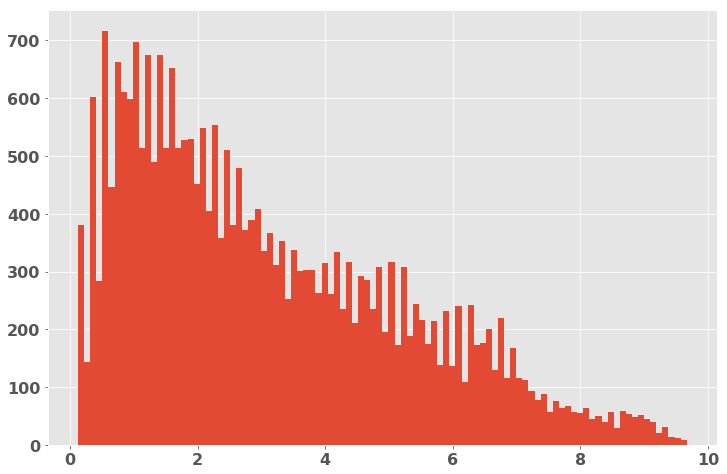

In [533]:
df_dist.distancia.hist(bins=100)

In [534]:
df_num_pozos_cercanos = pd.DataFrame(df_dist.groupby('Pozo').es_cercano.sum()).reset_index()
df_num_pozos_cercanos.columns = ['Pozo','num_pozos_a_menos_de_1km']
df_train = df_train.merge(df_num_pozos_cercanos, how='left',on='Pozo').dropna()

In [536]:
df_train.head()

,Pozo,fecha_produccion,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,diff_t_6_t_5,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,latitud,longitud,num_pozos_a_menos_de_1km
0,MOLOACAN-111,1999-01-01,169.92,159.46,193.95,169.10,182.03,177.28,191.66,10.46,...,0,1,0,0,0,0,0,17.985929,-94.370707,14
1,MOLOACAN-111,1999-02-01,159.46,193.95,169.10,182.03,177.28,191.66,186.59,-34.49,...,0,0,1,0,0,0,0,17.985929,-94.370707,14
2,MOLOACAN-111,1999-03-01,193.95,169.10,182.03,177.28,191.66,186.59,197.52,24.85,...,0,0,0,1,0,0,0,17.985929,-94.370707,14
3,MOLOACAN-111,1999-04-01,169.10,182.03,177.28,191.66,186.59,197.52,215.72,-12.93,...,0,0,0,0,1,0,0,17.985929,-94.370707,14
4,MOLOACAN-111,1999-05-01,182.03,177.28,191.66,186.59,197.52,215.72,185.47,4.75,...,0,0,0,0,0,1,0,17.985929,-94.370707,14


# Variable de tecnologia
Se le pega el nombre del equipo de perforacion para saber si es mejor o peor para la produccion

In [537]:
# pegar a pozo nombre_equipo_perfo
nombre_equi_perfo = pd.DataFrame(datos_generales_pozos.groupby(
    'NOMBRE_DE_POZO')['NOMBRE_EQUIPO_DE_PERFORACION'].first())
nombre_equi_perfo.reset_index(inplace=True)
nombre_equi_perfo.columns = ['Pozo','equipo_perforacion']
# se encontraron inconsistencias en la info
nombre_equi_perfo["equipo_perforacion"] = nombre_equi_perfo.equipo_perforacion.str.replace(
    "PM5597-","PM-5597").str.replace(
    "PM.-5597","PM-5597").str.replace(
    "PM.5599","PM-5599")
nombre_equi_perfo.head()

,Pozo,equipo_perforacion
0,MOLOACAN-1,SIN INFORMACION
1,MOLOACAN-101,SIN INFORMACION
2,MOLOACAN-102,SIN INFORMACION
3,MOLOACAN-102A,PM-5597
4,MOLOACAN-11,PM-111


In [538]:
df_train = df_train.merge(nombre_equi_perfo, how='left',on='Pozo').dropna()

In [539]:
df_train = pd.get_dummies(df_train, columns=['equipo_perforacion'])

In [540]:
df_train.shape

(19630, 83)

# variable clasificaccion LAHEE
La Clasificación Lahee, los pozos pueden ser identificados como:
+ Pozo Exploratorio
+ Pozos Productores
+ Pozos no Productores (Secos)
+ Pozos de Desarrollo
+ Pozo de Avanzada

Codigos

    07-07-01 - Pozo de desarrollo, productor aceite
    07-07-06 - Pozo de desarrollo, improductivo, invadido de agua salada
    07-07-13 - 07 Pozo de desarrollo
    07-07-04 - Pozo de desarrollo, productor incosteable
    07-07-07 - Pozo de desarrollo, improductivo seco
    04-04-01 - Pozo en busca de nueva acumulacion en campo ya productor, productor de aceite
    07-01-00 - 07 Pozo de desarrollo
    04-04-06 - Pozo en busca de nueva acumulacion en campo ya productor, improductivo, invadido de agua salada
    01-01-06 - Pozo en busca de nueva acumulacion, improductivo, invadido de agua salada
    SIN INFORMACION

Referencia de codigos https://bndh.gob.do/wp-content/uploads/2016/04/4.3-MEM-BNDH-RD-Tercer-Informe-de-Avances_v2-1.pdf


NO VALE LA PENA TODOS LOS POZOS SON DE DESARROLLO O SIN INFORMACION

In [541]:
# clasifi_lahee = pd.DataFrame(datos_generales_pozos.groupby(
#     'NOMBRE_DE_POZO')['CLASIFICACION_LAHEE'].first())
# clasifi_lahee.reset_index(inplace=True)
# clasifi_lahee.columns = ['Pozo','clasificacion_lahee']
# clasifi_lahee.head()

In [542]:
# df_train = df_train.merge(clasifi_lahee, how='left',on='Pozo').dropna()

In [543]:
# df_train = pd.get_dummies(df_train, columns=['clasificacion_lahee'])

In [646]:
# df_train.shape

In [647]:
# df_train.head()

# Saturacion y porosidad

In [650]:
datos_generales_pozos.columns

Index(['index', 'NOMBRE_DE_POZO', 'LATITUD', 'LONGITUD', 'ZONA_UTM',
       'COORDENADAS_UTM_X', 'COORDENADAS_UTM_Y', 'SISTEMA_DE_REFERENCIA',
       'NOMBRE_PLATAFORMA_PERA\n(Marino / Terrestre)',
       'NOMBRE_EQUIPO_DE_PERFORACION', 'TIPO_AGUJERO_(AGUJERO/REENTRADA)',
       'CLASIFICACION_POZO_(Exploratorio/Desarrollo)', 'CLASIFICACION_LAHEE',
       'ESTADO_ACTUAL_DE_POZO', 'TIRANTE_DE_AGUA_(m)',
       'PROFUNDIDAD_TOTAL_PERFORADA_(m)', 'PROFUNDIDAD_VERTICALIZADA_(m)',
       'PROFUNDIDAD_DE _REFERENCIA_(KB/MR/nivel_del_mar)',
       'ELEVACION_DE_REFERENCIA_(m)', 'ELEVACION_DE_TERRENO_(mTVD)',
       'TRAYECTORIA_(vertical/desviado/horizontal)',
       'TIPO_DE_HIDROCARBUROS_(aceite/gas/condensado)',
       'FECHA_INICIO_PERFORACION_(dd/mm/aaaa)',
       'FECHA_FIN_DE_PERFORACION_(dd/mm/aaaa)',
       'FECHA_DE_TERMINACION_(dd/mm/aaaa)',
       'FECHA_INICIO_PRODUCCION_(dd/mm/aaaa)',
       'FECHA_DE_TAPONAMIENTO_(dd/mm/aaaa)',
       'FORMACION_O_EDAD_(ULTIMA_PERFORADA)'],
   

In [649]:
datos_generales_pozos.head()

,index,NOMBRE_DE_POZO,LATITUD,LONGITUD,ZONA_UTM,COORDENADAS_UTM_X,COORDENADAS_UTM_Y,SISTEMA_DE_REFERENCIA,NOMBRE_PLATAFORMA_PERA (Marino / Terrestre),NOMBRE_EQUIPO_DE_PERFORACION,...,ELEVACION_DE_REFERENCIA_(m),ELEVACION_DE_TERRENO_(mTVD),TRAYECTORIA_(vertical/desviado/horizontal),TIPO_DE_HIDROCARBUROS_(aceite/gas/condensado),FECHA_INICIO_PERFORACION_(dd/mm/aaaa),FECHA_FIN_DE_PERFORACION_(dd/mm/aaaa),FECHA_DE_TERMINACION_(dd/mm/aaaa),FECHA_INICIO_PRODUCCION_(dd/mm/aaaa),FECHA_DE_TAPONAMIENTO_(dd/mm/aaaa),FORMACION_O_EDAD_(ULTIMA_PERFORADA)
0,0,MOLOACAN-1,17.987072,-94.381714,UTM-15,353703.80,1989180.10,NAD-27,MOLOACAN-1,SIN INFORMACION,...,24.48,22.48,VERTICAL,ACEITE/GAS,31/03/1949,16/04/1949,26/06/1949,12/03/1950,SIN INFORMACION,OLIGOCENO
1,1,MOLOACAN-101,17.982659,-94.369994,UTM-15,354941.32,1988682.58,NAD-27,MOLOACAN-101,SIN INFORMACION,...,27.43,24.93,VERTICAL,ACEITE/GAS,01/03/1949,14/03/1949,23/03/1949,SIN INFORMACION,23/03/1949,ENCANTO
2,2,MOLOACAN-102,17.982043,-94.367304,UTM-15,355225.64,1988612.31,NAD-27,MOLOACAN-102,SIN INFORMACION,...,30.75,28.27,VERTICAL,ACEITE/GAS,23/02/1949,04/03/1949,11/03/1949,SIN INFORMACION,12/03/1949,ENCANTO
3,3,MOLOACAN-102A,17.982088,-94.367397,UTM-15,355215.87,1988617.36,NAD-27,MOLOACAN-102,PM-5597,...,0.00,0.00,VERTICAL,ACEITE/GAS,19/07/1973,20/08/1973,20/08/1973,30/09/1973,SIN INFORMACION,ENCANTO
4,4,MOLOACAN-11,17.986597,-94.373105,UTM-15,354615.05,1989120.81,NAD-27,MOLOACAN-11,PM-111,...,38.36,34.45,VERTICAL,ACEITE/GAS,24/10/1966,07/11/1966,11/01/1967,23/11/1967,10/05/2002,ENCANTO


In [670]:
datos_generales_pozos['FORMACION_O_EDAD_(ULTIMA_PERFORADA)'].value_counts()

ENCANTO            273
ANHIDRITA           57
DEPOSITO            26
OLIGOCENO           22
SIN INFORMACION     11
SAL                  1
Name: FORMACION_O_EDAD_(ULTIMA_PERFORADA), dtype: int64

# HACE FALTA UNA BITACORA DE COMO FUERON SUBIENDO PARA PODER PEGAR TODA ESTA INFORMACION

# pendiente pico historico

In [546]:
# df_d_prod = db_prod_mol.groupby(['Pozo','fecha_produccion']).f_prod.first().shift(-6).reset_index()
# db_prod_mol['fecha_y'] = df_d_prod.f_prod

In [547]:
# for i in db_prod_mol.groupby('Pozo')[['Qo_mes_b','fecha_produccion','fecha_y']]:
#     print(i[0])
#     print(i[1][i[1].fecha_produccion >= i[1].fecha_y])

In [548]:
# y_temp = []
# for i in sample_prod_data.groupby('API')['Liquid']:
# #     print(i[0])
# #     print(i[1][i[1].index >= idx_prod_max_api[i[0]]].sum())
#     y_temp.append([i[0], i[1][i[1].index >= idx_prod_max_api[i[0]]].sum()])

In [549]:
# idx_prod_max_api = prod_data_train.groupby('API').Liquid.idxmax()

In [550]:
# # AQUI SE CREA LA Y (se puede hacer lista de comprension)
# pico_temp = []
# for i in db_prod_mol.groupby('Pozo')['Qo_mes_b']:
#     pico_temp.append([i[0], i[1][i[1].fecha_produccion >= idx_prod_max_api[i[0]]].sum()])

In [551]:
# db_prod_mol.columns

In [552]:
# db_prod_mol.groupby('Pozo')[['fecha_produccion','f_prod']].last()

In [553]:
# db_prod_mol.groupby(
#     ['Pozo','fecha_produccion'])

In [554]:
df_train.shape

(19630, 83)

## Quitamos Outliers

In [555]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t', 'diff_t_6_t_5',
       'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1',
       'diff_t_6_t_1', 'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'subio_t_6_t_5',
       'subio_t_5_t_4', 'subio_t_4_t_3', 'subio_t_3_t_2', 'subio_t_2_t_1',
       'num_subidas', 'bajo_t_6_t_5', 'bajo_t_5_t_4', 'bajo_t_4_t_3',
       'bajo_t_3_t_2', 'bajo_t_2_t_1', 'num_bajadas', 'std_t_6_t_1',
       'median_t_6_t_1', 'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1',
       'q90_t_6_t_1', 'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1',
       'media_movil_t_2_t_1', 'media_movil_t_3_t_1', 'media_movil_t_4_t_1',
       'media_movil_t_5_t_1', 'media_movil_t_6_t_1', 'dummi_p

In [556]:
df_train = df_train[df_train.Produccion_barriles_t > df_train.Produccion_barriles_t.quantile(0.005)]
df_train = df_train[df_train.Produccion_barriles_t_1 > df_train.Produccion_barriles_t_1.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_2 > df_train.Produccion_barriles_t_2.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_3 > df_train.Produccion_barriles_t_3.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_4 > df_train.Produccion_barriles_t_4.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_5 > df_train.Produccion_barriles_t_5.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_6 > df_train.Produccion_barriles_t_6.quantile(0.001)]

In [557]:
df_train = df_train[df_train.Produccion_barriles_t < df_train.Produccion_barriles_t.quantile(0.99)]

In [558]:
df_train = df_train[df_train.Produccion_barriles_t_1 < df_train.Produccion_barriles_t_1.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_2 < df_train.Produccion_barriles_t_2.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_3 < df_train.Produccion_barriles_t_3.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_4 < df_train.Produccion_barriles_t_4.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_5 < df_train.Produccion_barriles_t_5.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_6 < df_train.Produccion_barriles_t_6.quantile(0.99)]

In [559]:
df_train.reset_index(inplace=True, drop=True)

In [560]:
df_train.shape

(18046, 83)

# Clustering Vemos que hay tipos de pozos con produccion similar

In [561]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t', 'diff_t_6_t_5',
       'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1',
       'diff_t_6_t_1', 'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'subio_t_6_t_5',
       'subio_t_5_t_4', 'subio_t_4_t_3', 'subio_t_3_t_2', 'subio_t_2_t_1',
       'num_subidas', 'bajo_t_6_t_5', 'bajo_t_5_t_4', 'bajo_t_4_t_3',
       'bajo_t_3_t_2', 'bajo_t_2_t_1', 'num_bajadas', 'std_t_6_t_1',
       'median_t_6_t_1', 'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1',
       'q90_t_6_t_1', 'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1',
       'media_movil_t_2_t_1', 'media_movil_t_3_t_1', 'media_movil_t_4_t_1',
       'media_movil_t_5_t_1', 'media_movil_t_6_t_1', 'dummi_p

In [563]:
num_cols = ['Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1',
        'num_pozos_a_menos_de_1km',
        'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
            'subio_t_6_t_5',
       'subio_t_5_t_4', 'subio_t_4_t_3', 'subio_t_3_t_2', 'subio_t_2_t_1',
       'num_subidas', 'bajo_t_6_t_5', 'bajo_t_5_t_4', 'bajo_t_4_t_3',
       'bajo_t_3_t_2', 'bajo_t_2_t_1', 'num_bajadas',
       'aceleracion_de_produccion _t3t2_t2t1', 
            'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 
            'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1',
         'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 
            
        'Qg_mes_MMpc_t_6', 'Qg_mes_MMpc_t_5', 'Qg_mes_MMpc_t_4',
       'Qg_mes_MMpc_t_3', 'Qg_mes_MMpc_t_2', 'Qg_mes_MMpc_t_1',
            
       'latitud', 'longitud', 
            'equipo_perforacion_PM-113',
       'equipo_perforacion_PM-472', 'equipo_perforacion_PM-504',
       'equipo_perforacion_PM-5571', 'equipo_perforacion_PM-5596',
       'equipo_perforacion_PM-5597', 'equipo_perforacion_PM-5599',
       'equipo_perforacion_PM-5620', 'equipo_perforacion_PM-5626',
       'equipo_perforacion_PM-5627', 'equipo_perforacion_PM-73',
       'equipo_perforacion_PM-78', 'equipo_perforacion_PM-92',
       'equipo_perforacion_SIN INFORMACION']

In [564]:
df_std = (df_train[num_cols] - df_train[num_cols].mean()) / df_train[num_cols].std()

In [565]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, n_jobs=6)
    km = km.fit(df_std)
    Sum_of_squared_distances.append(km.inertia_)

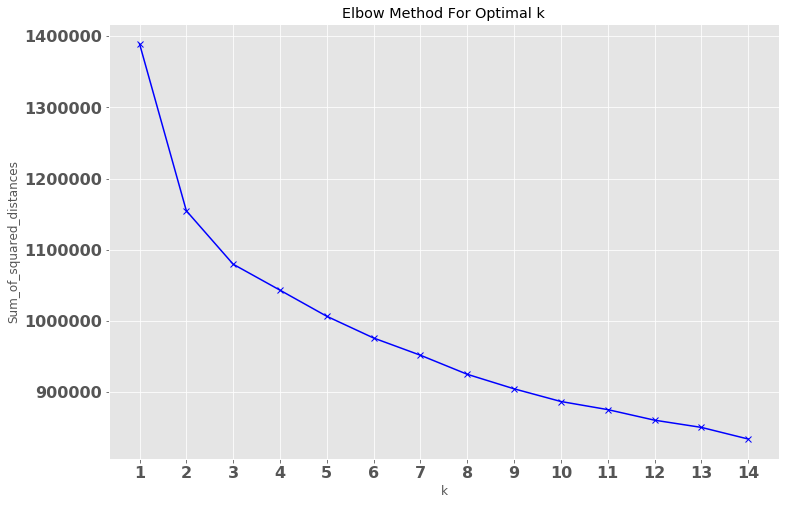

In [566]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.xticks(np.arange(1,15));

In [567]:
kmeans = KMeans(n_clusters=5, n_jobs=6)
kmeans.fit(df_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=6, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [568]:
df_train = pd.concat([df_train, pd.get_dummies(kmeans.predict(df_std),prefix="cluster")],1).dropna()

In [569]:
df_train["cluster"] = kmeans.predict(df_std)

Si ayuda agregar clusters, vemos que hay pozos que producen menos.

# Caracteristicas del pozo

In [570]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t', 'diff_t_6_t_5',
       'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1',
       'diff_t_6_t_1', 'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'subio_t_6_t_5',
       'subio_t_5_t_4', 'subio_t_4_t_3', 'subio_t_3_t_2', 'subio_t_2_t_1',
       'num_subidas', 'bajo_t_6_t_5', 'bajo_t_5_t_4', 'bajo_t_4_t_3',
       'bajo_t_3_t_2', 'bajo_t_2_t_1', 'num_bajadas', 'std_t_6_t_1',
       'median_t_6_t_1', 'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1',
       'q90_t_6_t_1', 'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1',
       'media_movil_t_2_t_1', 'media_movil_t_3_t_1', 'media_movil_t_4_t_1',
       'media_movil_t_5_t_1', 'media_movil_t_6_t_1', 'dummi_p

# AED

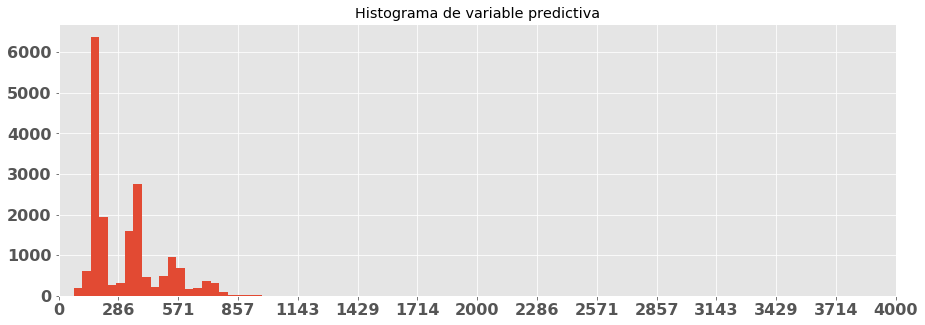

In [571]:
df_train.Produccion_barriles_t.hist(bins=25, figsize=(15,5))
plt.title('Histograma de variable predictiva')
plt.xticks(np.linspace(0,4000,15));

# Dispersiones

In [572]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t', 'diff_t_6_t_5',
       'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1',
       'diff_t_6_t_1', 'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'subio_t_6_t_5',
       'subio_t_5_t_4', 'subio_t_4_t_3', 'subio_t_3_t_2', 'subio_t_2_t_1',
       'num_subidas', 'bajo_t_6_t_5', 'bajo_t_5_t_4', 'bajo_t_4_t_3',
       'bajo_t_3_t_2', 'bajo_t_2_t_1', 'num_bajadas', 'std_t_6_t_1',
       'median_t_6_t_1', 'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1',
       'q90_t_6_t_1', 'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1',
       'media_movil_t_2_t_1', 'media_movil_t_3_t_1', 'media_movil_t_4_t_1',
       'media_movil_t_5_t_1', 'media_movil_t_6_t_1', 'dummi_p

In [573]:
num_cols = ['Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 
            'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 
            'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 
#             'detenido_mes_antes',
       'latitud', 'longitud',
            'equipo_perforacion_PM-113',
       'equipo_perforacion_PM-472', 'equipo_perforacion_PM-504',
       'equipo_perforacion_PM-5571', 'equipo_perforacion_PM-5596',
       'equipo_perforacion_PM-5597', 'equipo_perforacion_PM-5599',
       'equipo_perforacion_PM-5620', 'equipo_perforacion_PM-5626',
       'equipo_perforacion_PM-5627', 'equipo_perforacion_PM-73',
       'equipo_perforacion_PM-78', 'equipo_perforacion_PM-92',
       'equipo_perforacion_SIN INFORMACION', 'clasificacion_lahee_07-07-01',
       'clasificacion_lahee_SIN INRMACION', 
            'cluster_0', 'cluster_1',
       'cluster_2', 'cluster_3', 'cluster_4', 'cluster']

En algun momento dibujaras un mapa aqui

In [574]:
lat = df_train.groupby('Pozo')[['latitud','longitud']].first().latitud.values
lon = df_train.groupby('Pozo')[['latitud','longitud']].first().latitud.values
idx = df_train.groupby('Pozo')[['latitud','longitud']].first().index.values

In [625]:
df_prod_heatmap = df_train.set_index('fecha_produccion').groupby(['Pozo',pd.Grouper(freq='1Y')]).Produccion_barriles_t.sum()

Text(0.5, 1.0, 'Produccion anual por pozo, historia')

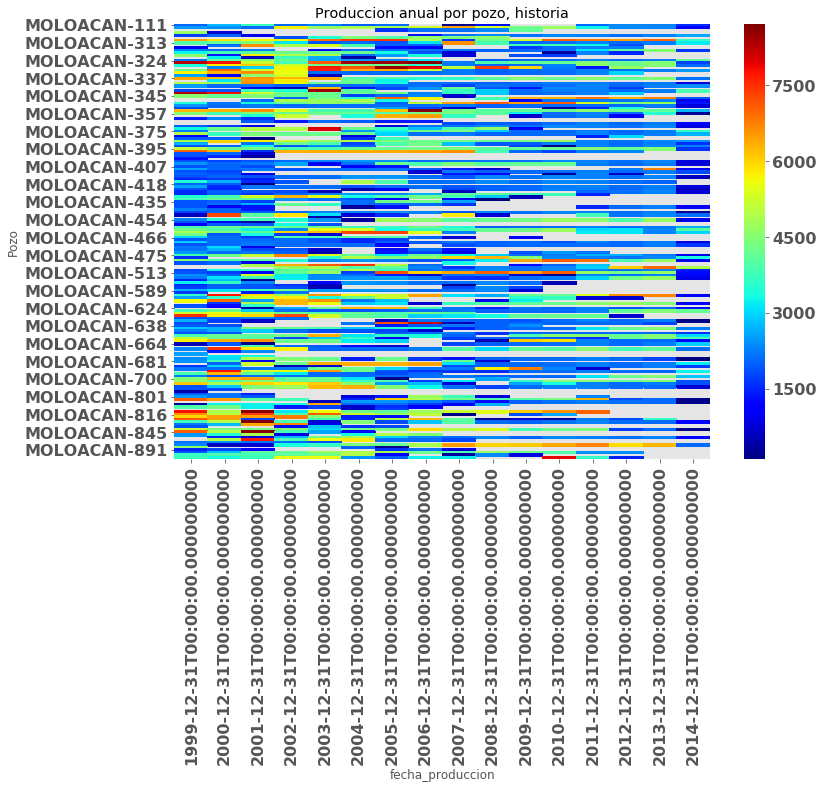

In [635]:
sns.heatmap(df_prod_heatmap.unstack(),cmap='jet')
plt.title('Produccion anual por pozo, historia')

In [639]:
df_prod_heatmap = df_prod_heatmap.reset_index()

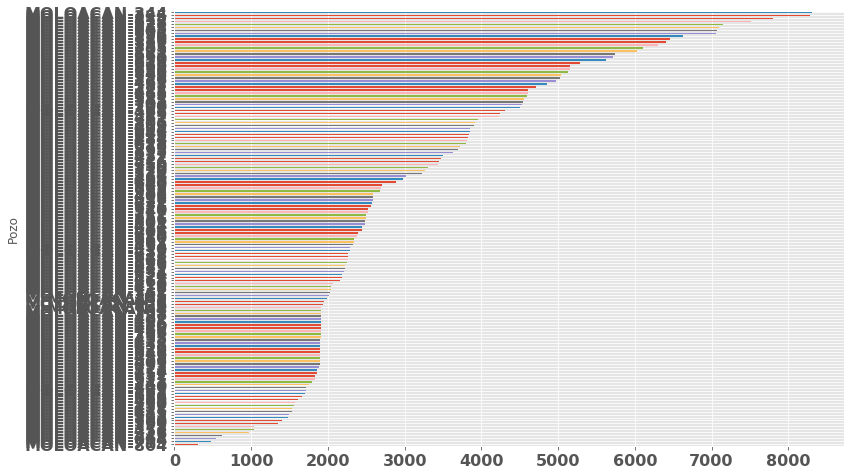

In [645]:
df_prod_heatmap[df_prod_heatmap.fecha_produccion == '1999-12-31'].merge(
    lat_lon_pozo[['Pozo','latitud','longitud']], on='Pozo').set_index('Pozo').Produccion_barriles_t.sort_values().plot.barh()

# heatmap por produccion Pendiente

Text(0.5, 1.0, 'Observamos que hay pozos estables en cantidad de produccion y\n            otros que ascienden o descienden en produccion')

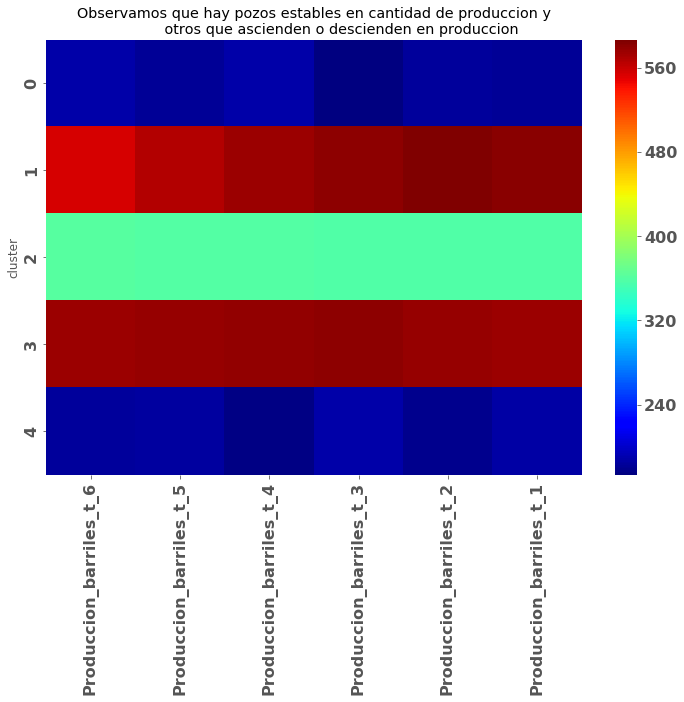

In [576]:
sns.heatmap(df_train.groupby('cluster')[[ 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1']].mean(),cmap='jet')
plt.title('''Observamos que hay pozos estables en cantidad de produccion y
            otros que ascienden o descienden en produccion''')

# Entrenamiento

In [577]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t', 'diff_t_6_t_5',
       'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1',
       'diff_t_6_t_1', 'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'subio_t_6_t_5',
       'subio_t_5_t_4', 'subio_t_4_t_3', 'subio_t_3_t_2', 'subio_t_2_t_1',
       'num_subidas', 'bajo_t_6_t_5', 'bajo_t_5_t_4', 'bajo_t_4_t_3',
       'bajo_t_3_t_2', 'bajo_t_2_t_1', 'num_bajadas', 'std_t_6_t_1',
       'median_t_6_t_1', 'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1',
       'q90_t_6_t_1', 'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1',
       'media_movil_t_2_t_1', 'media_movil_t_3_t_1', 'media_movil_t_4_t_1',
       'media_movil_t_5_t_1', 'media_movil_t_6_t_1', 'dummi_p

In [578]:
num_cols =['Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 
           'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
            'subio_t_6_t_5',
       'subio_t_5_t_4', 'subio_t_4_t_3', 'subio_t_3_t_2', 'subio_t_2_t_1',
       'num_subidas', 'bajo_t_6_t_5', 'bajo_t_5_t_4', 'bajo_t_4_t_3',
       'bajo_t_3_t_2', 'bajo_t_2_t_1', 'num_bajadas',
       'aceleracion_de_produccion _t3t2_t2t1',
           'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 
           'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 
            'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12',
        'Qg_mes_MMpc_t_6', 'Qg_mes_MMpc_t_5', 'Qg_mes_MMpc_t_4',
       'Qg_mes_MMpc_t_3', 'Qg_mes_MMpc_t_2', 'Qg_mes_MMpc_t_1',
       'latitud', 'longitud',
           'equipo_perforacion_PM-113',
       'equipo_perforacion_PM-472', 'equipo_perforacion_PM-504',
       'equipo_perforacion_PM-5571', 'equipo_perforacion_PM-5596',
       'equipo_perforacion_PM-5597', 'equipo_perforacion_PM-5599',
       'equipo_perforacion_PM-5620', 'equipo_perforacion_PM-5626',
       'equipo_perforacion_PM-5627', 'equipo_perforacion_PM-73',
       'equipo_perforacion_PM-78', 'equipo_perforacion_PM-92',
       'equipo_perforacion_SIN INFORMACION',
           'cluster_0', 'cluster_1',
       'cluster_2', 'cluster_3', 'cluster_4',
           
          'num_pozos_a_menos_de_1km']

In [579]:
x_train, x_test, x_valid, y_train, y_test, y_valid = st.train_test_valid_split(df_train, num_cols, 'Produccion_barriles_t')

# Conjunto de validacion

In [580]:
y_valid.index.tolist()

[15917,
 10205,
 2296,
 111,
 1550,
 4382,
 4746,
 6688,
 6014,
 223,
 7447,
 4405,
 16907,
 4566,
 15839,
 13756,
 4823,
 11023,
 9111,
 10962,
 1633,
 12517,
 5057,
 15405,
 16530,
 15311,
 7093,
 10256,
 12017,
 1175,
 16613,
 6303,
 16276,
 4031,
 12839,
 5003,
 12301,
 169,
 3696,
 11139,
 4727,
 1908,
 12070,
 574,
 10002,
 16452,
 3535,
 365,
 17874,
 7403,
 13385,
 15158,
 10323,
 12338,
 1833,
 4393,
 5508,
 3409,
 5157,
 6107,
 1579,
 10975,
 2249,
 5963,
 12979,
 9762,
 11646,
 3580,
 13311,
 5631,
 3638,
 10526,
 5331,
 9167,
 17807,
 8463,
 9086,
 9601,
 13993,
 12728,
 13468,
 8960,
 11281,
 11300,
 6957,
 9294,
 5811,
 5836,
 1302,
 14418,
 15538,
 4843,
 11700,
 10967,
 14681,
 5542,
 13930,
 13097,
 1503,
 5326,
 1354,
 10933,
 16818,
 9396,
 644,
 12950,
 13193,
 3460,
 3389,
 11073,
 7786,
 14277,
 2993,
 2045,
 8015,
 6195,
 8321,
 967,
 13288,
 9660,
 2548,
 12907,
 10181,
 12074,
 1865,
 2639,
 16205,
 8163,
 156,
 5598,
 15833,
 13412,
 3290,
 6027,
 17286,
 6649,
 8866,
 17108,
 8730,
 15969,
 1882,
 273,
 1389,
 12546,
 3022,
 2429,
 13595,
 14635,
 14049,
 12981,
 14628,
 8469,
 17795,
 10255,
 6691,
 8889,
 10277,
 13610,
 16503,
 16909,
 13099,
 16108,
 1114,
 9761,
 3739,
 16033,
 15680,
 16702,
 4321,
 526,
 8826,
 2866,
 17660,
 10365,
 331,
 4154,
 1811,
 2416,
 5962,
 5674,
 11404,
 3368,
 14600,
 2792,
 9418,
 3245,
 11548,
 14750,
 3345,
 11192,
 3039,
 12021,
 8713,
 6073,
 835,
 12541,
 6245,
 7676,
 10654,
 3213,
 8925,
 8851,
 7101,
 1777,
 7351,
 17166,
 10567,
 568,
 14468,
 5327,
 17318,
 14694,
 6653,
 5741,
 11525,
 243,
 17721,
 10303,
 5952,
 6032,
 1331,
 16179,
 9767,
 4248,
 16727,
 9448,
 5178,
 9026,
 4076,
 16487,
 15232,
 5438,
 159,
 14962,
 16098,
 11090,
 7533,
 17223,
 4914,
 10141,
 676,
 2836,
 6772,
 1996,
 7538,
 9137,
 9061,
 14636,
 13526,
 7843,
 1982,
 2282,
 1123,
 16084,
 9099,
 15413,
 17071,
 16002,
 16647,
 2882,
 10994,
 256,
 13944,
 288,
 10126,
 3399,
 3759,
 1318,
 13305,
 17234,
 10781,
 18028,
 10392,
 4517,
 12883,
 13876,
 2100,
 8975,
 3772,
 15625,
 13731,
 11717,
 17675,
 16450,
 14723,
 11898,
 4810,
 1647,
 7609,
 6535,
 13226,
 11050,
 5040,
 8794,
 2097,
 9777,
 17637,
 2303,
 16980,
 13016,
 2808,
 17080,
 13376,
 268,
 1531,
 10614,
 13118,
 5933,
 13076,
 2305,
 13200,
 14458,
 15252,
 2961,
 14483,
 15191,
 3106,
 782,
 7936,
 4593,
 13709,
 10147,
 2027,
 8103,
 17024,
 8355,
 8846,
 6578,
 13529,
 14194,
 8482,
 6118,
 12672,
 4016,
 12832,
 5783,
 8048,
 15159,
 7867,
 16184,
 10836,
 5859,
 1133,
 1010,
 8658,
 13292,
 15153,
 10454,
 3706,
 11010,
 4147,
 17139,
 1390,
 13058,
 15063,
 206,
 14985,
 8800,
 13981,
 6329,
 7187,
 16392,
 1760,
 12385,
 9282,
 1261,
 8626,
 14931,
 1013,
 8581,
 8723,
 17498,
 2092,
 17217,
 9571,
 799,
 6878,
 14897,
 6891,
 15011,
 942,
 3692,
 10444,
 13268,
 896,
 11482,
 3464,
 4084,
 12430,
 12611,
 858,
 7828,
 4003,
 890,
 9358,
 9896,
 17000,
 10410,
 13922,
 6043,
 15737,
 14708,
 3217,
 12178,
 2694,
 5258,
 12780,
 4722,
 10483,
 8139,
 654,
 6258,
 16621,
 7963,
 1319,
 15277,
 17002,
 11267,
 14909,
 2712,
 6723,
 176,
 9488,
 1858,
 3812,
 16349,
 10948,
 11514,
 15147,
 11613,
 13151,
 8207,
 9081,
 8203,
 14519,
 5550,
 1410,
 4890,
 1226,
 16075,
 1299,
 7479,
 10222,
 5253,
 5820,
 17932,
 4947,
 14744,
 10916,
 10502,
 15658,
 15721,
 13673,
 9564,
 17356,
 13962,
 15812,
 13684,
 7747,
 6222,
 13455,
 6351,
 2671,
 9003,
 15056,
 4544,
 4978,
 15891,
 11437,
 1379,
 4708,
 11733,
 5523,
 7149,
 16850,
 17627,
 5887,
 11756,
 17307,
 8864,
 4841,
 7272,
 10127,
 2806,
 10492,
 15896,
 473,
 56,
 4450,
 12863,
 8404,
 9838,
 929,
 13323,
 11308,
 10764,
 15442,
 6171,
 10202,
 12328,
 10115,
 17365,
 4293,
 11266,
 15227,
 7546,
 11600,
 8498,
 3925,
 13839,
 7861,
 14272,
 17375,
 14844,
 10273,
 8962,
 9631,
 3774,
 4901,
 7608,
 16483,
 14875,
 17786,
 8236,
 4014,
 8142,
 2595,
 1157,
 2582,
 3406,
 11818,
 3906,
 17442,
 436,
 14285,
 4015,
 6382,
 9721,
 5313,
 12439,
 4058,
 13

# seguimos entrenando

In [581]:
x_train.shape

(12992, 82)

In [582]:
d_train = lgb.Dataset(x_train, y_train)
d_test = lgb.Dataset(x_test, label=y_test)

params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.5
params['num_leaves'] = 50
params['min_data'] = 1
params['max_depth'] = -1
params['num_iterations'] = 100000

clf = lgb.train(params, d_train, 1000, valid_sets=[d_test], early_stopping_rounds=25,verbose_eval=10000)

Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[2217]	valid_0's l1: 20.7579


In [583]:
clf.num_trees()

2217

# Evaluacion

In [584]:
y_pred = clf.predict(x_valid)

In [585]:
from sklearn import metrics
def report_evaluation_regression(y_real, y_pred, num_features):
    """Reporte de evaluacion,
    y_real, y_pred=y_estimada,num_features=numero de variables"""
    R2=metrics.r2_score(y_real,y_pred)
    n=len(y_real)
    p=num_features
    r2 = 1-(1-R2)*(n-1)/(n-p-1)
    
    
    print("R^2: %1.4f" % R2)
    
    print("R^2 ajustada$: %1.4f" % r2)
    
    print("MEA: %1.4f" % metrics.mean_absolute_error(y_real,y_pred))
    print("MSE %1.4f" % metrics.mean_squared_error(y_real,y_pred))
    print("RMSE %1.4f" % np.sqrt(metrics.mean_squared_error(y_real,y_pred)))
    

In [586]:
report_evaluation_regression(y_valid, y_pred, x_train.shape[1])

$R^2$: 0.8944
$R^2$ ajustada$: 0.8894
MEA: 20.7928
MSE 3078.3180
RMSE 55.4826


In [587]:
def yy_plot(y_real, y_pred):
    plt.scatter(y_real, y_pred, alpha=0.5)
    mi2,ma2 = y_real.min(), y_real.max()
    mi1,ma1 = y_pred.min(), y_pred.max()
    plt.plot([mi2,ma2],[mi1,ma1], linestyle='--', color='navy')
    plt.xlabel('Y_real')
    plt.ylabel('Y_estimada')

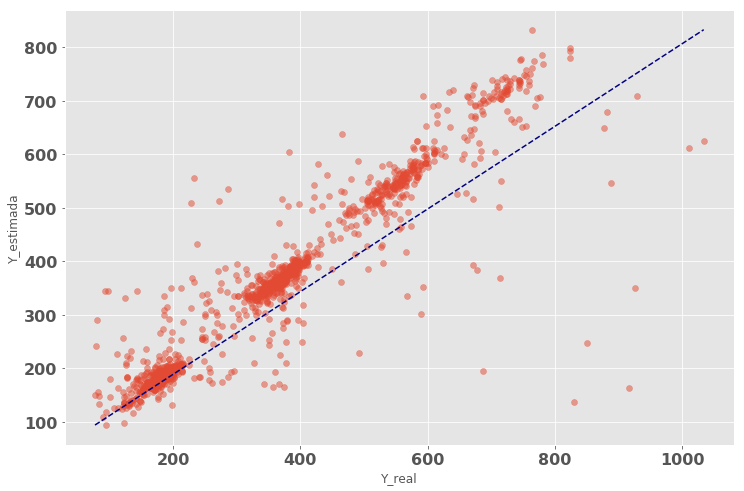

In [588]:
yy_plot(y_valid, y_pred)

## Residuos

In [589]:
res = (y_valid - y_pred) / y_valid

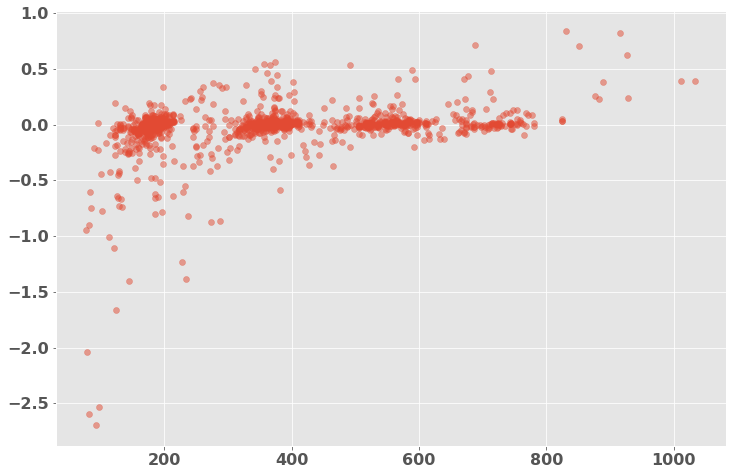

In [590]:
plt.scatter(y_valid, res, alpha=0.5)

In [591]:
res.median() * 100

0.15287840754630277

In [592]:
res.mean() * 100

-1.6171493467221398

## Autocorrelacion

Blogs indican que es mejor hacer la estimacion de $\hat{y}=P(t)-P(t-1)=\alpha + \sum {\beta X_i} + \epsilon$

Se generan mas variables para ayudarle al modelo

# Interpretacion

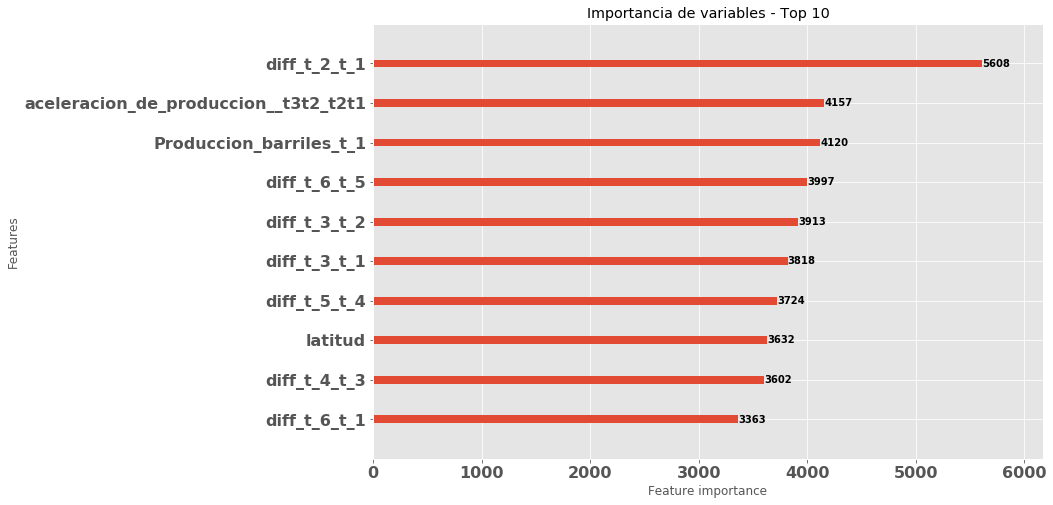

In [593]:
lgb.plot_importance(clf,max_num_features=10, title='Importancia de variables - Top 10')

In [594]:
explainer, shap_values = st.shap_shap(clf, x_valid)

In [595]:
shap.force_plot(explainer.expected_value, shap_values[5,:], x_valid.iloc[5,:])

## Efectos Marginales

In [596]:
a = pd.DataFrame(clf.feature_importance(), index=x_valid.columns,
             columns=['imp']).sort_values('imp')

In [597]:
a.tail(8).index

Index(['latitud', 'diff_t_5_t_4', 'diff_t_3_t_1', 'diff_t_3_t_2',
       'diff_t_6_t_5', 'Produccion_barriles_t_1',
       'aceleracion_de_produccion _t3t2_t2t1', 'diff_t_2_t_1'],
      dtype='object')

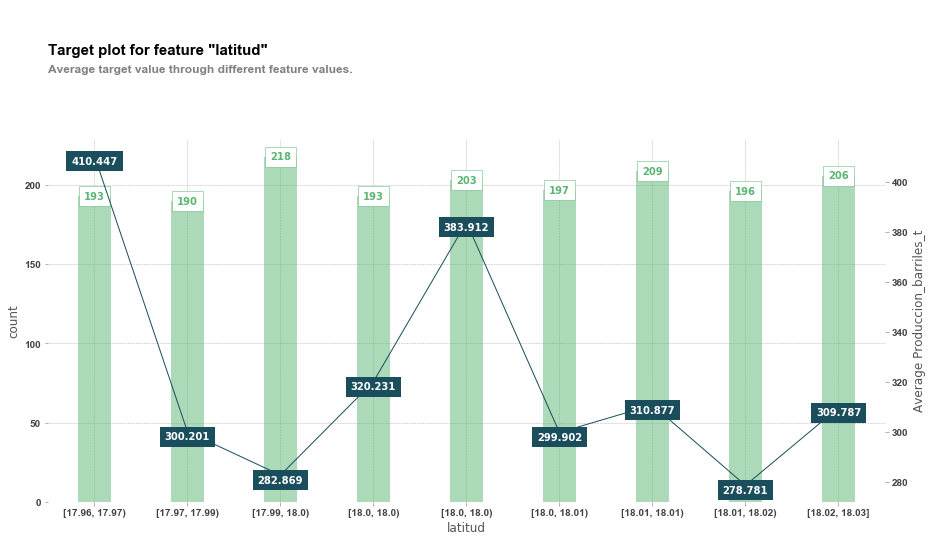

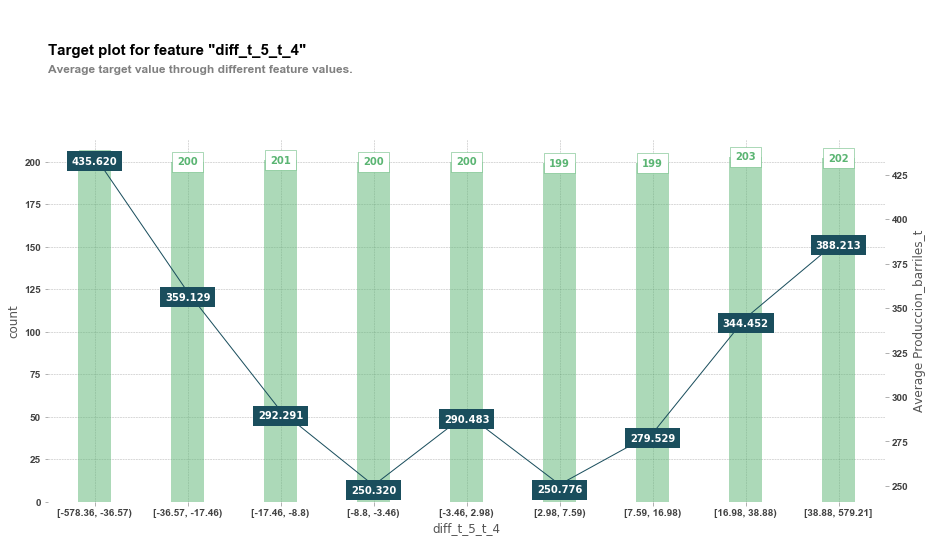

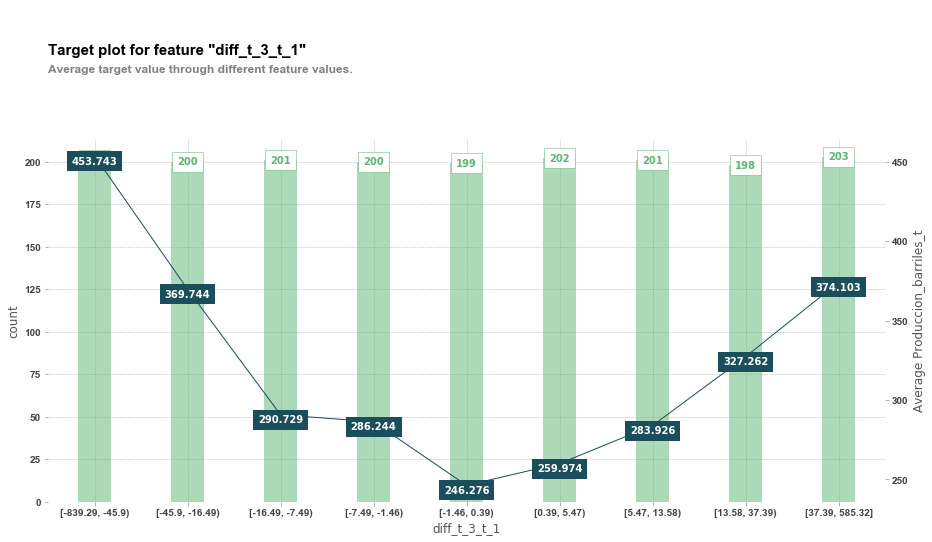

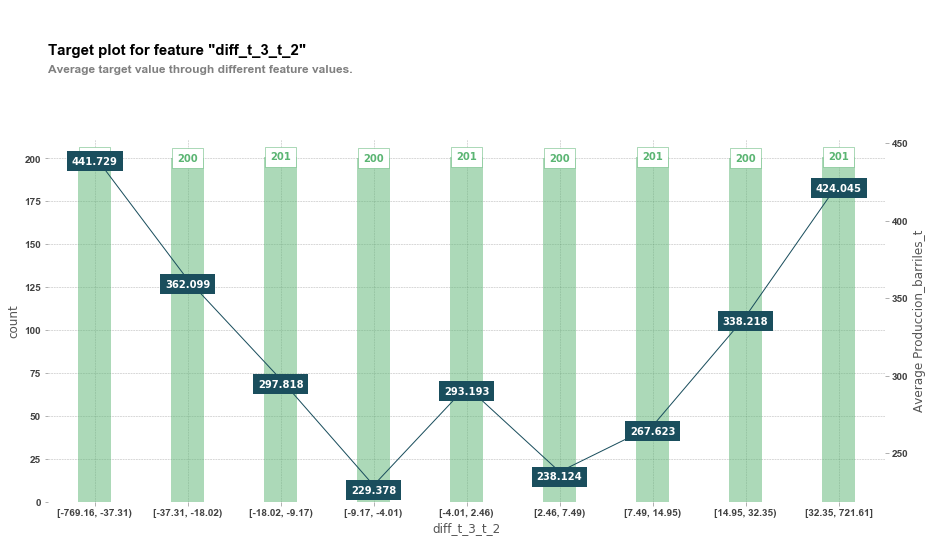

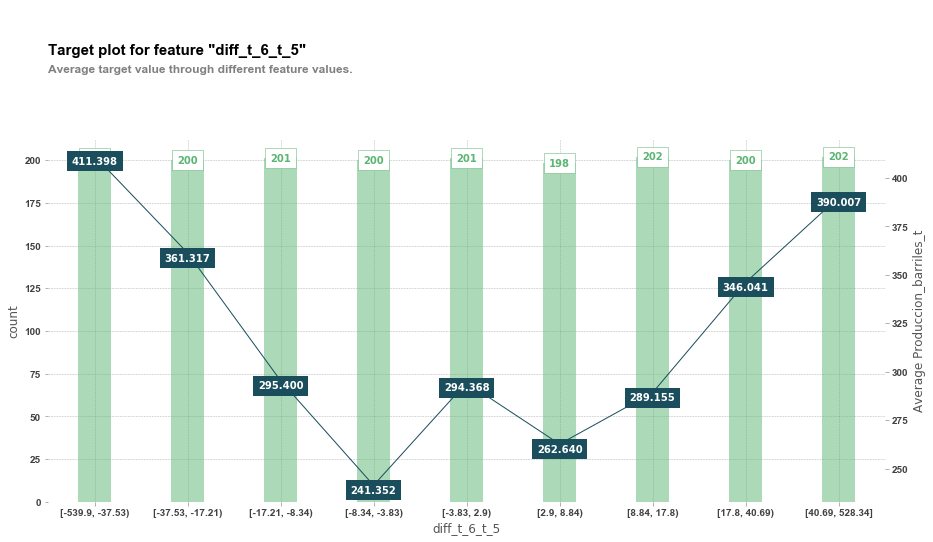

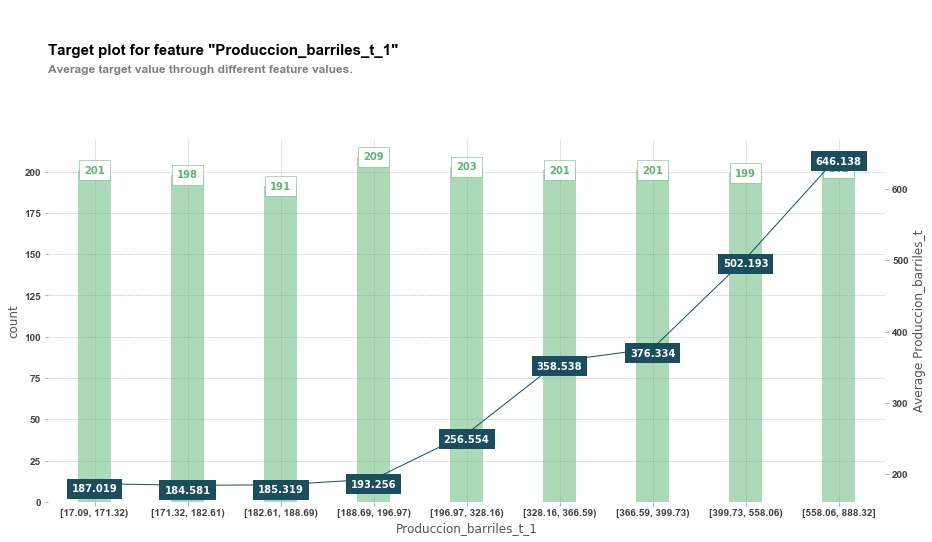

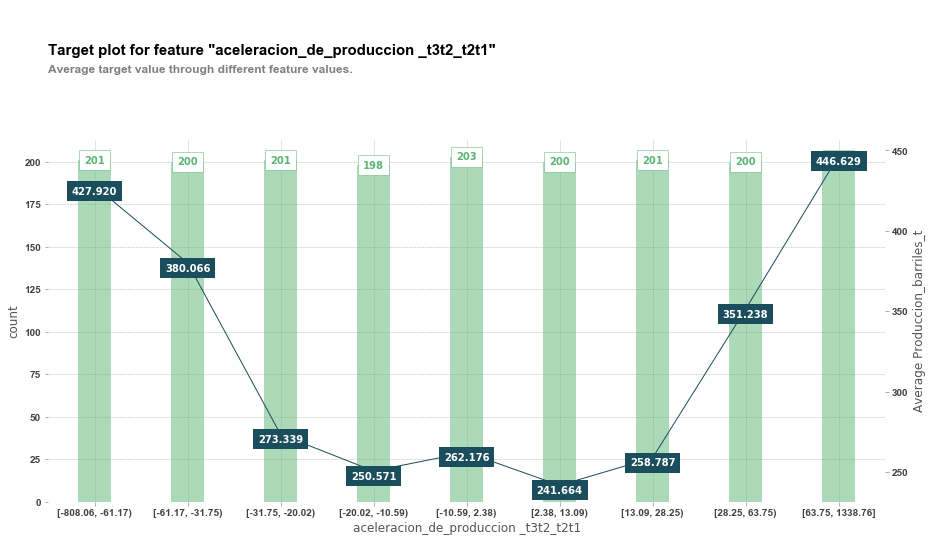

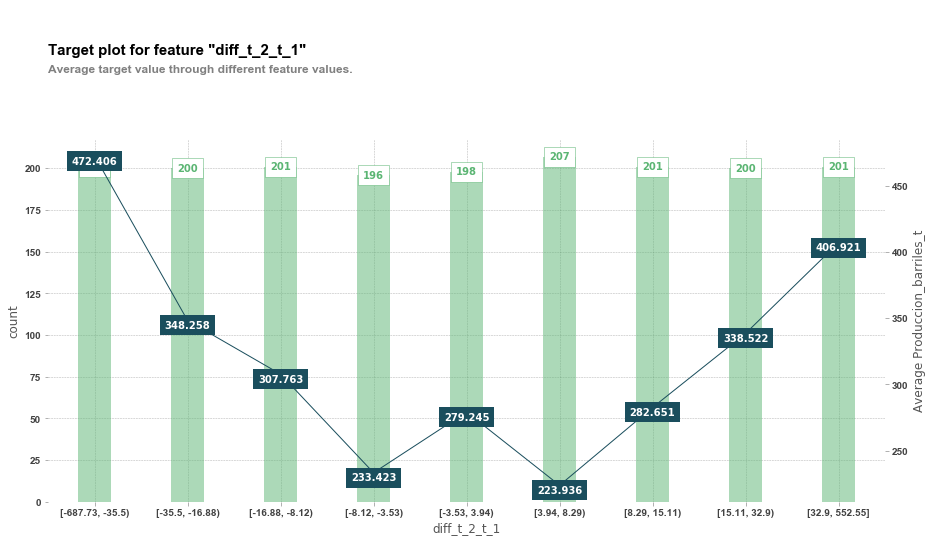

In [598]:
for col in a.tail(8).index:
    fig, axes, summary_df = info_plots.target_plot(
        df=pd.concat([x_valid,y_valid],1)
        , feature=col, 
        feature_name=col, 
        target='Produccion_barriles_t'
    )

## Pendiente interpretar los de shap

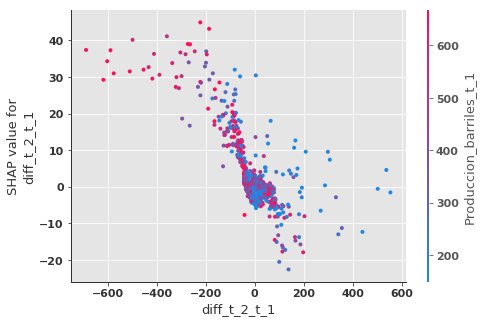

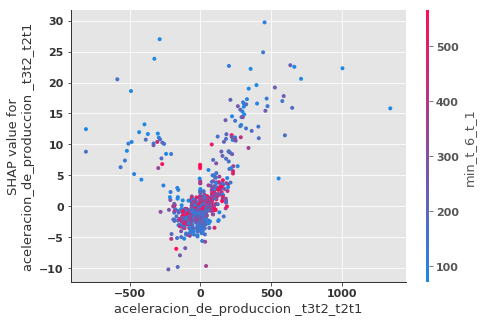

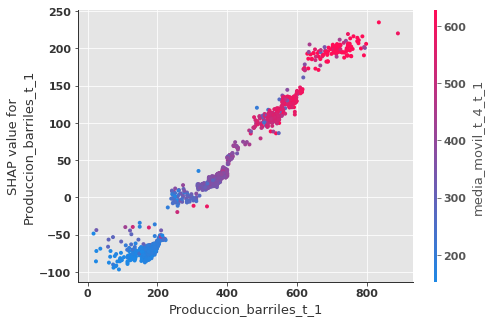

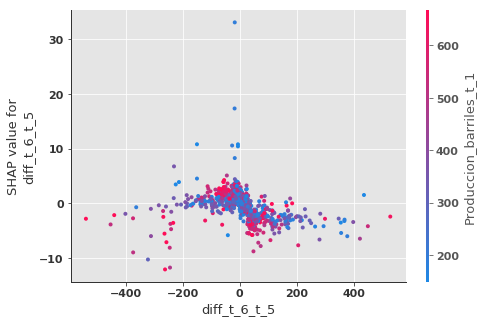

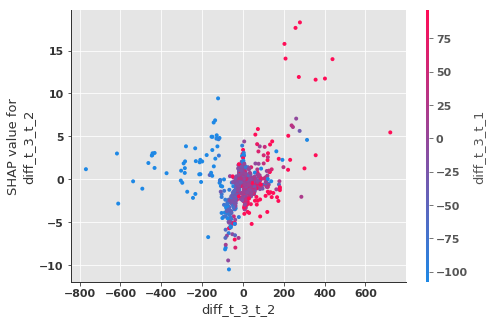

In [599]:
for col in a.sort_values('imp',ascending=False).head(5).index:
    shap.dependence_plot(col, shap_values, x_valid)

# Guardado de mejor modelo

In [285]:
from sklearn.externals import joblib
joblib.dump(clf, 'light_gbm_31-07-2019.pkl')
# load model
# gbm_pickle = joblib.load('light_gbm_31-07-2019.pkl')

['light_gbm_31-07-2019.pkl']

In [290]:
# carga de modelo
gbm_pickle = joblib.load('modelos/light_gbm_31-07-2019.pkl')

# Check de pozos aleatorios

In [162]:
idx = df_train.Pozo.sample(10)

In [163]:
index = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Produccion_barriles_t.first().index

In [164]:
validacion = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Produccion_barriles_t.first().unstack(0)

In [165]:
prediction = clf.predict(df_train[df_train.Pozo.isin(idx)][num_cols])

In [166]:
prediccion_validacion = pd.DataFrame(prediction,columns=['prediction']).set_index(index).unstack(0)

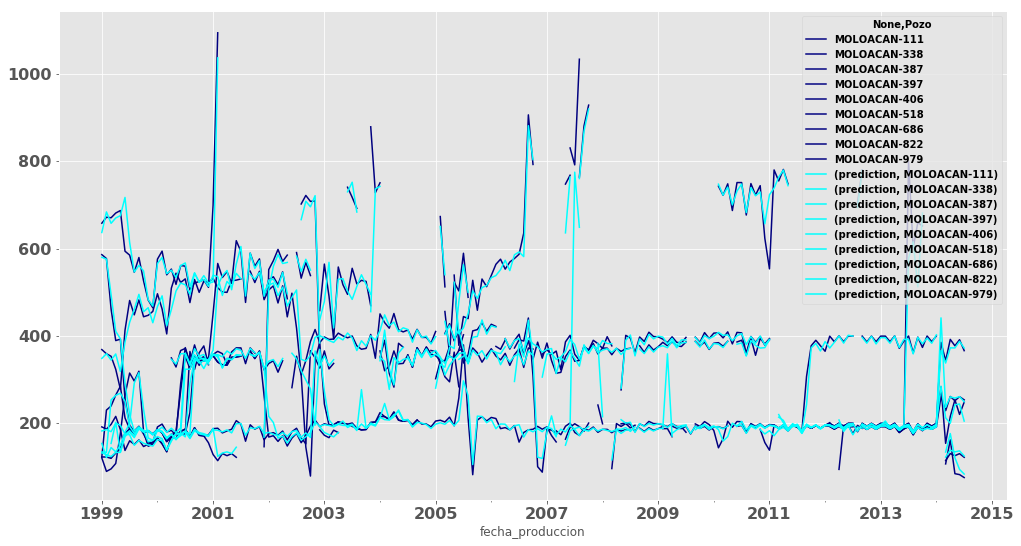

In [167]:
ax = validacion.plot(figsize=(17,9),color='navy')
prediccion_validacion.plot(ax = ax,color='cyan')

In [168]:
# pd.merge(validacion,prediccion_validacion,right_index=True, left_index=True).iplot()

# Pozo promedio

In [169]:
preds = clf.predict(df_train[num_cols])
real = df_train.Produccion_barriles_t

In [170]:
df_train['prediction'] = preds

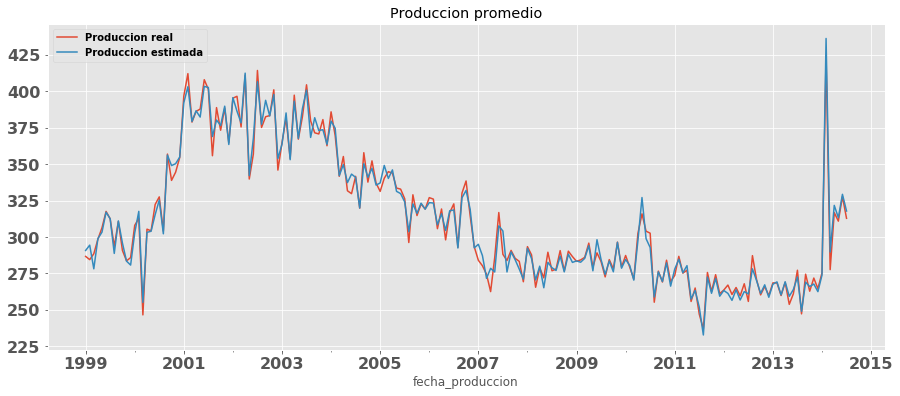

In [171]:
df_train.groupby('fecha_produccion')[['Produccion_barriles_t','prediction']].mean().plot(
    figsize=(15,6), title='Produccion promedio')
plt.legend(['Produccion real', 'Produccion estimada'])

# Pozo Tipo Promedio Base 0
Seleccionar pozos que tengan al menos 10 anios de vida

En promedio tienen 110 mediciones, es decir, al menos 9 anios de vida

In [172]:
 df_train.groupby('Pozo').fecha_produccion.count().median()

105.5

In [173]:
pozos_vivos = df_train.groupby('Pozo').fecha_produccion.count()[df_train.groupby('Pozo').fecha_produccion.count() > 110].index

In [174]:
df_vivos = df_train[df_train.Pozo.isin(pozos_vivos)]

In [175]:
# ax = df_vivos.groupby('fecha_produccion')[['Qomes_b_t','prediction']].mean().plot(
#     figsize=(15,6), title='Produccion promedio en un pozo tipo base 0',linewidth=4.0)

# ax.fill_between(sorted(df_vivos.fecha_produccion.unique()), 
#                 df_vivos.groupby('fecha_produccion')['prediction'].mean(),
#                 df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.90),
#                alpha=0.3, color='navy')

# ax.fill_between(sorted(df_vivos.fecha_produccion.unique()), 
#                 df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.10),
#                 df_vivos.groupby('fecha_produccion')['prediction'].mean(),
#                alpha=0.3, color='navy')

# plt.legend(['Produccion real', 'Produccion estimada','quantil-90','quantil-10'])

In [291]:
df_vivos2 = df_vivos.groupby('fecha_produccion')[['Produccion_barriles_t','prediction']].mean()
df_vivos2["Qomes_b_t_q90"] = df_vivos.groupby('fecha_produccion')['Produccion_barriles_t'].quantile(0.90)
df_vivos2["Qomes_b_t_q10"] = df_vivos.groupby('fecha_produccion')['Produccion_barriles_t'].quantile(0.10)
df_vivos2["prediccion_q90"] = df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.90)
df_vivos2["prediccion_q10"] = df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.10)
df_vivos2['residuo'] = df_vivos2.Produccion_barriles_t - df_vivos2.prediction

In [292]:
df_vivos2.iplot(title='Perfiles de pozos con su estimacion')

# Generador de serie de tiempo

In [ ]:
df_simul = df_train[df_train.Pozo == 'MOLOACAN-836'].reset_index(drop=True)
df_simul.drop(['Qomes_b_t_log','cluster'], 1, inplace=True)
df_simul['y_real'] = df_simul.Qomes_b_t
# se selecciono aleatoriamente

In [ ]:
df_simul.columns

In [ ]:
def gen_cols(df):
    
    df['diff_t_6_t_5'] = df['Qomes_b_t_6'] - df['Qomes_b_t_5']
    df['diff_t_5_t_4'] = df['Qomes_b_t_5'] - df['Qomes_b_t_4']
    df['diff_t_4_t_3'] = df['Qomes_b_t_4'] - df['Qomes_b_t_3']
    df['diff_t_3_t_2'] = df['Qomes_b_t_3'] - df['Qomes_b_t_2']
    df['diff_t_2_t_1'] = df['Qomes_b_t_2'] - df['Qomes_b_t_1']

    df['std_t_6_t_1'] = df[['Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
                        'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1']].std(1)
    df['mean_t_6_t_1'] = df[['Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
                        'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1']].mean(1)
    df['median_t_6_t_1'] = df[['Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
                        'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1']].median(1)
    df['min_t_6_t_1'] = df[['Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
                        'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1']].min(1) 
    df['max_t_6_t_1'] = df[['Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
                        'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1']].max(1)
    return df

In [ ]:
gen_cols(df_simulation)